In [2]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [11]:
with xr.open_dataset('glc1-a/nc/glc1-a_dx_50_NT_2000_dt_1.0_MB_-1.5_volumetric_prog_gridded.nc') as src: 
    src = src.isel(heat_source=0, dt=0, Delta_MB=0, T_ma=0)


(1900.0, 2948.7549420055257)

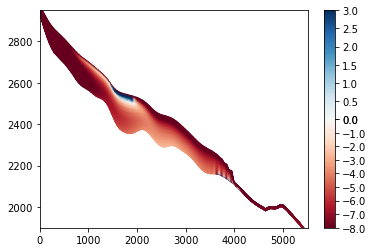

In [12]:
fig, ax = plt.subplots(1,1) 
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = colors.TwoSlopeNorm(vmin=-8., vcenter=0, vmax=3)
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html#twoslopenorm-different-mapping-on-either-side-of-a-center
# https://matplotlib.org/stable/gallery/scales/custom_scale.html


im = ax.pcolormesh(src.X[:,::-1], 
                   src.Z.isel(t=-1), 
                   xr.where(src.enthalpy_h >= src['phase change enthalpy'], 
                   src['water content']*100, src['temperature']).isel(t=-1), 
                   shading='gouraud', norm=divnorm, cmap='RdBu') 

cb = fig.colorbar(im)
cb.set_ticks(np.concatenate((np.linspace(-8, 0, 9), 
                             np.linspace(0.0, 3.0, 7))))

ax.set_xlim(None, 5.5e3)
ax.set_ylim(1900, None)
# fig.savefig('figs/Temp_Tma_-5.0_MB_-1.225_@2kya.png', dpi=300, bbox_inches='tight', facecolor='w')

In [38]:
np.concatenate((np.linspace(-8, 0, 9), np.linspace(0.0, 3.0, 7)))

array([-8. , -7. , -6. , -5. , -4. , -3. , -2. , -1. ,  0. ,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ])

In [ ]:
(src.enthalpy_h.mean(('coord_2', 'coord_1'))/1e3).plot(x="t")
(src.enthalpy_h.isel(coord_2=slice(0,-3)).mean(('coord_2', 'coord_1'))/1e3).plot(x="t")
